# install dependencies


In [1]:
## Install dependencies
!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install text-unidecode

# ## Install NeMo
BRANCH = 'main'
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[asr]

## Install TorchAudio
!pip install torchaudio -f https://download.pytorch.org/whl/torch_stable.html

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=cbf413e69304fedb2a609748fd547ecb671a955f276b67631131f8d52f3bc504
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libsndfile1 is already the newest version (1.0.31-2ubuntu0.1).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
The following additional packages will be installed:
  libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa libsox-fmt-base libsox3 libwavpack1
Suggested packages:
  libsox-fmt-all
The following NEW packages will be installed:
  libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa libsox-fmt-base libsox3 libwavpack1 sox
0 upgraded, 7 newly installed, 0 to remove and 29 not upgraded.
Need to get 617 kB of archives.
After this operation, 1,764 kB of additi

# mount google drive

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
import os

source = '/gdrive/MyDrive/denoised_source'
data_dir = os.path.join('data')
os.makedirs(data_dir, exist_ok=True)
seasons = os.listdir(source)
print(f"all seasons: {seasons}")

eps = []
for season in seasons:
  for ep in os.listdir(os.path.join(source, season)):
    eps.append(os.path.join(source, season, ep))
ROOT = os.getcwd()

all seasons: ['S1', 'S2']


In [4]:
audio = eps[0]

In [5]:
import wave

def print_wav_info(file_path):
    with wave.open(file_path, 'rb') as wav_file:
        print("Sample Width:", wav_file.getsampwidth())
        print("Channels:", wav_file.getnchannels())
        print("Frame Rate (Sample Rate):", wav_file.getframerate())
        print("Number of Frames:", wav_file.getnframes())
        print("Compression Type:", wav_file.getcomptype())
        print("Compression Name:", wav_file.getcompname())

print(audio)
print_wav_info(audio)


/gdrive/MyDrive/denoised_source/S1/EP1.wav
Sample Width: 2
Channels: 1
Frame Rate (Sample Rate): 44100
Number of Frames: 66151296
Compression Type: NONE
Compression Name: not compressed


Audio Signal Shape: (24000471,)
Sampling Rate: 16000
Duration (seconds): 1500.0294375


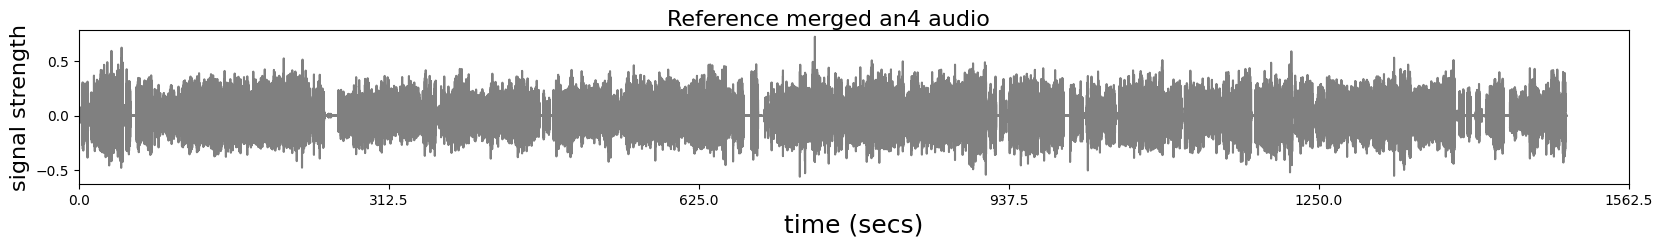

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import librosa

sr = 16000
signal, sr = librosa.load(audio, sr=sr)

print("Audio Signal Shape:", signal.shape)
print("Sampling Rate:", sr)
print("Duration (seconds):", librosa.get_duration(y=signal, sr=sr))

fig,ax = plt.subplots(1,1)
fig.set_figwidth(20)
fig.set_figheight(2)
plt.plot(np.arange(len(signal)),signal,'gray')
fig.suptitle('Reference merged an4 audio', fontsize=16)
plt.xlabel('time (secs)', fontsize=18)
ax.margins(x=0)
plt.ylabel('signal strength', fontsize=16);
a,_ = plt.xticks();plt.xticks(a,a/sr);


In [7]:
# Create a manifest for input with below format.
# {'audio_filepath': /path/to/audio_file, 'offset': 0, 'duration':None, 'label': 'infer', 'text': '-',
# 'num_speakers': None, 'rttm_filepath': /path/to/rttm/file, 'uem_filepath'='/path/to/uem/filepath'}
import json
def make_manifest(path: str):
  meta = {
      'audio_filepath': path,
      'offset': 0,
      'duration':None,
      'label': 'infer',
      'text': '-',
      'num_speakers': None,
      'rttm_filepath': None,
      'uem_filepath' : None
  }
  with open('data/input_manifest.json','w') as fp:
      json.dump(meta,fp)
      fp.write('\n')


In [8]:
import wget
from omegaconf import OmegaConf
MODEL_CONFIG = os.path.join(data_dir,'diar_infer_telephonic.yaml')
if not os.path.exists(MODEL_CONFIG):
    config_url = "https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/speaker_tasks/diarization/conf/inference/diar_infer_telephonic.yaml"
    MODEL_CONFIG = wget.download(config_url,data_dir)

config = OmegaConf.load(MODEL_CONFIG)
print(OmegaConf.to_yaml(config))

name: ClusterDiarizer
num_workers: 1
sample_rate: 16000
batch_size: 64
device: null
verbose: true
diarizer:
  manifest_filepath: ???
  out_dir: ???
  oracle_vad: false
  collar: 0.25
  ignore_overlap: true
  vad:
    model_path: vad_multilingual_marblenet
    external_vad_manifest: null
    parameters:
      window_length_in_sec: 0.15
      shift_length_in_sec: 0.01
      smoothing: median
      overlap: 0.5
      onset: 0.1
      offset: 0.1
      pad_onset: 0.1
      pad_offset: 0
      min_duration_on: 0
      min_duration_off: 0.2
      filter_speech_first: true
  speaker_embeddings:
    model_path: titanet_large
    parameters:
      window_length_in_sec:
      - 1.5
      - 1.25
      - 1.0
      - 0.75
      - 0.5
      shift_length_in_sec:
      - 0.75
      - 0.625
      - 0.5
      - 0.375
      - 0.25
      multiscale_weights:
      - 1
      - 1
      - 1
      - 1
      - 1
      save_embeddings: true
  clustering:
    parameters:
      oracle_num_speakers: false
      max

In [9]:
pretrained_vad = 'vad_multilingual_marblenet'
pretrained_speaker_model = 'titanet_large'

In [10]:
output_dir = os.path.join(ROOT, 'outputs')

In [11]:
config.diarizer.manifest_filepath = 'data/input_manifest.json'
config.diarizer.out_dir = output_dir # Directory to store intermediate files and prediction outputs
pretrained_speaker_model = 'titanet_large'
config.diarizer.speaker_embeddings.model_path = pretrained_speaker_model
config.diarizer.speaker_embeddings.parameters.window_length_in_sec = [1.5,1.25,1.0,0.75,0.5]
config.diarizer.speaker_embeddings.parameters.shift_length_in_sec = [0.75,0.625,0.5,0.375,0.1]
config.diarizer.speaker_embeddings.parameters.multiscale_weights= [1,1,1,1,1]
config.diarizer.clustering.parameters.max_num_speakers = 20

config.diarizer.speaker_embeddings.model_path = pretrained_speaker_model
config.diarizer.oracle_vad = False # compute VAD provided with model_path to vad config
config.diarizer.clustering.parameters.oracle_num_speakers=False

config.diarizer.msdd_model.model_path = 'diar_msdd_telephonic' # Telephonic speaker diarization model
config.diarizer.msdd_model.parameters.sigmoid_threshold = [0.7, 1.0] # Evaluate with T=0.7 and T=1.0

# Here, we use our in-house pretrained NeMo VAD model
config.diarizer.vad.model_path = pretrained_vad
config.diarizer.vad.parameters.onset = 0.8
config.diarizer.vad.parameters.offset = 0.6
config.diarizer.vad.parameters.pad_offset = -0.05

config.batch_size = 128

In [12]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()

from nemo.collections.asr.models import ClusteringDiarizer
sd_model = ClusteringDiarizer(cfg=config)

[NeMo W 2024-01-19 07:48:38 transformer_bpe_models:62] Could not import NeMo NLP collection which is required for speech translation model.


[NeMo I 2024-01-19 07:48:38 clustering_diarizer:127] Loading pretrained vad_multilingual_marblenet model from NGC
[NeMo I 2024-01-19 07:48:38 cloud:68] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/vad_multilingual_marblenet/versions/1.10.0/files/vad_multilingual_marblenet.nemo to /root/.cache/torch/NeMo/NeMo_1.23.0rc0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo
[NeMo I 2024-01-19 07:48:39 common:913] Instantiating model from pre-trained checkpoint


[NeMo W 2024-01-19 07:48:39 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/ami_train_0.63.json,/manifests/freesound_background_train.json,/manifests/freesound_laughter_train.json,/manifests/fisher_2004_background.json,/manifests/fisher_2004_speech_sampled.json,/manifests/google_train_manifest.json,/manifests/icsi_all_0.63.json,/manifests/musan_freesound_train.json,/manifests/musan_music_train.json,/manifests/musan_soundbible_train.json,/manifests/mandarin_train_sample.json,/manifests/german_train_sample.json,/manifests/spanish_train_sample.json,/manifests/french_train_sample.json,/manifests/russian_train_sample.json
    sample_rate: 16000
    labels:
    - background
    - speech
    batch_size: 256
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: sca

[NeMo I 2024-01-19 07:48:39 features:289] PADDING: 16
[NeMo I 2024-01-19 07:48:39 save_restore_connector:249] Model EncDecClassificationModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0rc0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-01-19 07:48:39 clustering_diarizer:157] Loading pretrained titanet_large model from NGC
[NeMo I 2024-01-19 07:48:39 cloud:68] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/titanet_large/versions/v1/files/titanet-l.nemo to /root/.cache/torch/NeMo/NeMo_1.23.0rc0/titanet-l/11ba0924fdf87c049e339adbf6899d48/titanet-l.nemo
[NeMo I 2024-01-19 07:48:44 common:913] Instantiating model from pre-trained checkpoint


[NeMo W 2024-01-19 07:48:45 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2024-01-19 07:48:45 modelPT:168] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method 

[NeMo I 2024-01-19 07:48:45 features:289] PADDING: 16
[NeMo I 2024-01-19 07:48:45 save_restore_connector:249] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0rc0/titanet-l/11ba0924fdf87c049e339adbf6899d48/titanet-l.nemo.


In [13]:
import shutil

for ep in eps:
  # clear both ram and vram
  gc.collect()
  torch.cuda.empty_cache()

  rel_path = os.path.relpath(ep, source)
  print(f'processing: {rel_path}')

  make_manifest(ep)
  sd_model.diarize()
  # TODO: save to gdrive
  file_name_without_extension, file_extension = os.path.splitext(os.path.basename(ep))
  directory_path = os.path.dirname(ep)

  source_path = f'{output_dir}/pred_rttms/{file_name_without_extension}.rttm'
  destination = os.path.join(directory_path, f'{file_name_without_extension}.rttm')
  shutil.copy(source_path, destination)

  print(f'finish processing: {rel_path}')

processing: S1/EP1.wav
[NeMo I 2024-01-19 07:48:46 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-01-19 07:48:46 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

[NeMo I 2024-01-19 07:48:47 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-01-19 07:48:47 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:48:47 collections:446] Dataset loaded with 31 items, total duration of  0.42 hours.
[NeMo I 2024-01-19 07:48:47 collections:448] # 31 files loaded accounting to # 1 labels



vad: 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]

[NeMo I 2024-01-19 07:48:57 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-01-19 07:49:14 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it]

[NeMo I 2024-01-19 07:49:17 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-01-19 07:49:17 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:49:17 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:49:17 collections:446] Dataset loaded with 886 items, total duration of  0.22 hours.
[NeMo I 2024-01-19 07:49:17 collections:448] # 886 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]

[NeMo I 2024-01-19 07:49:21 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 07:49:22 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-01-19 07:49:22 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:49:22 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:49:22 collections:446] Dataset loaded with 1011 items, total duration of  0.23 hours.
[NeMo I 2024-01-19 07:49:22 collections:448] # 1011 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 8/8 [00:05<00:00,  1.46it/s]

[NeMo I 2024-01-19 07:49:27 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 07:49:27 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-01-19 07:49:27 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:49:27 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:49:27 collections:446] Dataset loaded with 1183 items, total duration of  0.24 hours.
[NeMo I 2024-01-19 07:49:27 collections:448] # 1183 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


[NeMo I 2024-01-19 07:49:33 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 07:49:33 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-01-19 07:49:33 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:49:33 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:49:33 collections:446] Dataset loaded with 1513 items, total duration of  0.26 hours.
[NeMo I 2024-01-19 07:49:33 collections:448] # 1513 files loaded accounting to # 1 labels


[4/5] extract embeddings: 100%|██████████| 12/12 [00:07<00:00,  1.71it/s]

[NeMo I 2024-01-19 07:49:40 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 07:49:40 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/outputs/speaker_outputs/subsegments_scale4.json


[NeMo I 2024-01-19 07:49:40 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:49:40 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:49:40 collections:446] Dataset loaded with 4398 items, total duration of  0.58 hours.
[NeMo I 2024-01-19 07:49:40 collections:448] # 4398 files loaded accounting to # 1 labels


[5/5] extract embeddings: 100%|██████████| 35/35 [00:18<00:00,  1.90it/s]


[NeMo I 2024-01-19 07:50:00 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings


clustering: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it]

[NeMo I 2024-01-19 07:50:02 clustering_diarizer:464] Outputs are saved in /content/outputs directory



[NeMo W 2024-01-19 07:50:02 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


finish processing: S1/EP1.wav


[NeMo W 2024-01-19 07:50:03 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


processing: S1/EP2.wav
[NeMo I 2024-01-19 07:50:03 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-01-19 07:50:03 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]

[NeMo I 2024-01-19 07:50:05 vad_utils:107] The prepared manifest file exists. Overwriting!
[NeMo I 2024-01-19 07:50:05 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-01-19 07:50:05 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:50:05 collections:446] Dataset loaded with 29 items, total duration of  0.40 hours.
[NeMo I 2024-01-19 07:50:05 collections:448] # 29 files loaded accounting to # 1 labels



vad: 100%|██████████| 29/29 [00:08<00:00,  3.51it/s]

[NeMo I 2024-01-19 07:50:13 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-01-19 07:50:25 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

[NeMo I 2024-01-19 07:50:27 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-01-19 07:50:27 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:50:27 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:50:27 collections:446] Dataset loaded with 829 items, total duration of  0.18 hours.
[NeMo I 2024-01-19 07:50:27 collections:448] # 829 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 7/7 [00:03<00:00,  1.85it/s]

[NeMo I 2024-01-19 07:50:31 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 07:50:31 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-01-19 07:50:31 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:50:31 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:50:31 collections:446] Dataset loaded with 934 items, total duration of  0.19 hours.
[NeMo I 2024-01-19 07:50:31 collections:448] # 934 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]

[NeMo I 2024-01-19 07:50:35 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 07:50:35 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-01-19 07:50:35 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:50:35 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:50:35 collections:446] Dataset loaded with 1060 items, total duration of  0.20 hours.
[NeMo I 2024-01-19 07:50:35 collections:448] # 1060 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 9/9 [00:05<00:00,  1.71it/s]

[NeMo I 2024-01-19 07:50:40 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 07:50:40 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-01-19 07:50:40 clustering_diarizer:343] Extracting embeddings for Diarization


[NeMo I 2024-01-19 07:50:40 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:50:40 collections:446] Dataset loaded with 1332 items, total duration of  0.21 hours.
[NeMo I 2024-01-19 07:50:40 collections:448] # 1332 files loaded accounting to # 1 labels


[4/5] extract embeddings: 100%|██████████| 11/11 [00:05<00:00,  1.89it/s]


[NeMo I 2024-01-19 07:50:46 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 07:50:46 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/outputs/speaker_outputs/subsegments_scale4.json
[NeMo I 2024-01-19 07:50:46 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:50:46 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:50:46 collections:446] Dataset loaded with 3597 items, total duration of  0.47 hours.
[NeMo I 2024-01-19 07:50:46 collections:448] # 3597 files loaded accounting to # 1 labels


[5/5] extract embeddings: 100%|██████████| 29/29 [00:15<00:00,  1.92it/s]


[NeMo I 2024-01-19 07:51:02 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings


clustering: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

[NeMo I 2024-01-19 07:51:03 clustering_diarizer:464] Outputs are saved in /content/outputs directory



[NeMo W 2024-01-19 07:51:03 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


finish processing: S1/EP2.wav


[NeMo W 2024-01-19 07:51:04 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


processing: S1/EP3.wav
[NeMo I 2024-01-19 07:51:04 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-01-19 07:51:04 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:05<00:00,  5.63s/it]

[NeMo I 2024-01-19 07:51:09 vad_utils:107] The prepared manifest file exists. Overwriting!
[NeMo I 2024-01-19 07:51:09 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-01-19 07:51:09 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:51:09 collections:446] Dataset loaded with 29 items, total duration of  0.40 hours.
[NeMo I 2024-01-19 07:51:09 collections:448] # 29 files loaded accounting to # 1 labels



vad: 100%|██████████| 29/29 [00:07<00:00,  3.96it/s]

[NeMo I 2024-01-19 07:51:17 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-01-19 07:51:30 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

[NeMo I 2024-01-19 07:51:31 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-01-19 07:51:31 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:51:31 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:51:31 collections:446] Dataset loaded with 731 items, total duration of  0.16 hours.
[NeMo I 2024-01-19 07:51:31 collections:448] # 731 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 6/6 [00:03<00:00,  1.74it/s]

[NeMo I 2024-01-19 07:51:35 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 07:51:35 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-01-19 07:51:35 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:51:35 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:51:35 collections:446] Dataset loaded with 820 items, total duration of  0.17 hours.
[NeMo I 2024-01-19 07:51:35 collections:448] # 820 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]

[NeMo I 2024-01-19 07:51:39 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 07:51:39 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-01-19 07:51:39 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:51:39 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:51:39 collections:446] Dataset loaded with 947 items, total duration of  0.18 hours.
[NeMo I 2024-01-19 07:51:39 collections:448] # 947 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


[NeMo I 2024-01-19 07:51:44 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 07:51:44 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-01-19 07:51:44 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:51:44 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:51:44 collections:446] Dataset loaded with 1181 items, total duration of  0.19 hours.
[NeMo I 2024-01-19 07:51:44 collections:448] # 1181 files loaded accounting to # 1 labels


[4/5] extract embeddings: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]

[NeMo I 2024-01-19 07:51:49 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 07:51:49 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/outputs/speaker_outputs/subsegments_scale4.json


[NeMo I 2024-01-19 07:51:49 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:51:49 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:51:49 collections:446] Dataset loaded with 3239 items, total duration of  0.43 hours.
[NeMo I 2024-01-19 07:51:49 collections:448] # 3239 files loaded accounting to # 1 labels


[5/5] extract embeddings: 100%|██████████| 26/26 [00:13<00:00,  1.91it/s]


[NeMo I 2024-01-19 07:52:03 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings


clustering: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

[NeMo I 2024-01-19 07:52:04 clustering_diarizer:464] Outputs are saved in /content/outputs directory



[NeMo W 2024-01-19 07:52:04 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


finish processing: S1/EP3.wav


[NeMo W 2024-01-19 07:52:05 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


processing: S1/EP4.wav
[NeMo I 2024-01-19 07:52:05 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-01-19 07:52:05 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:05<00:00,  5.12s/it]

[NeMo I 2024-01-19 07:52:10 vad_utils:107] The prepared manifest file exists. Overwriting!
[NeMo I 2024-01-19 07:52:10 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-01-19 07:52:10 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:52:10 collections:446] Dataset loaded with 29 items, total duration of  0.40 hours.
[NeMo I 2024-01-19 07:52:10 collections:448] # 29 files loaded accounting to # 1 labels



vad: 100%|██████████| 29/29 [00:06<00:00,  4.39it/s]

[NeMo I 2024-01-19 07:52:17 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-01-19 07:52:30 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

[NeMo I 2024-01-19 07:52:31 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-01-19 07:52:31 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:52:31 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:52:31 collections:446] Dataset loaded with 797 items, total duration of  0.17 hours.
[NeMo I 2024-01-19 07:52:31 collections:448] # 797 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]

[NeMo I 2024-01-19 07:52:35 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings


[NeMo I 2024-01-19 07:52:35 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-01-19 07:52:35 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:52:35 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:52:35 collections:446] Dataset loaded with 876 items, total duration of  0.18 hours.
[NeMo I 2024-01-19 07:52:35 collections:448] # 876 files loaded accounting to # 1 labels


[2/5] extract embeddings: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]

[NeMo I 2024-01-19 07:52:40 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 07:52:40 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-01-19 07:52:40 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:52:40 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:52:40 collections:446] Dataset loaded with 1006 items, total duration of  0.19 hours.
[NeMo I 2024-01-19 07:52:40 collections:448] # 1006 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 8/8 [00:04<00:00,  1.71it/s]

[NeMo I 2024-01-19 07:52:45 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 07:52:45 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-01-19 07:52:45 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:52:45 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:52:45 collections:446] Dataset loaded with 1251 items, total duration of  0.20 hours.
[NeMo I 2024-01-19 07:52:45 collections:448] # 1251 files loaded accounting to # 1 labels



[4/5] extract embeddings: 100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


[NeMo I 2024-01-19 07:52:54 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 07:52:54 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/outputs/speaker_outputs/subsegments_scale4.json
[NeMo I 2024-01-19 07:52:54 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:52:54 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:52:54 collections:446] Dataset loaded with 3315 items, total duration of  0.43 hours.
[NeMo I 2024-01-19 07:52:54 collections:448] # 3315 files loaded accounting to # 1 labels


[5/5] extract embeddings: 100%|██████████| 26/26 [00:18<00:00,  1.43it/s]


[NeMo I 2024-01-19 07:53:13 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings


clustering: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

[NeMo I 2024-01-19 07:53:14 clustering_diarizer:464] Outputs are saved in /content/outputs directory



[NeMo W 2024-01-19 07:53:14 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


finish processing: S1/EP4.wav


[NeMo W 2024-01-19 07:53:15 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


processing: S1/EP5.wav
[NeMo I 2024-01-19 07:53:15 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-01-19 07:53:15 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:03<00:00,  3.98s/it]

[NeMo I 2024-01-19 07:53:19 vad_utils:107] The prepared manifest file exists. Overwriting!
[NeMo I 2024-01-19 07:53:19 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-01-19 07:53:19 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:53:19 collections:446] Dataset loaded with 29 items, total duration of  0.40 hours.
[NeMo I 2024-01-19 07:53:19 collections:448] # 29 files loaded accounting to # 1 labels



vad: 100%|██████████| 29/29 [00:08<00:00,  3.44it/s]


[NeMo I 2024-01-19 07:53:27 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-01-19 07:53:41 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

[NeMo I 2024-01-19 07:53:42 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-01-19 07:53:42 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:53:42 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:53:42 collections:446] Dataset loaded with 697 items, total duration of  0.14 hours.
[NeMo I 2024-01-19 07:53:42 collections:448] # 697 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 6/6 [00:03<00:00,  1.87it/s]


[NeMo I 2024-01-19 07:53:45 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 07:53:45 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-01-19 07:53:45 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:53:45 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:53:45 collections:446] Dataset loaded with 769 items, total duration of  0.15 hours.
[NeMo I 2024-01-19 07:53:45 collections:448] # 769 files loaded accounting to # 1 labels


[2/5] extract embeddings: 100%|██████████| 7/7 [00:03<00:00,  1.90it/s]

[NeMo I 2024-01-19 07:53:49 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 07:53:49 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-01-19 07:53:49 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:53:49 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:53:49 collections:446] Dataset loaded with 869 items, total duration of  0.16 hours.
[NeMo I 2024-01-19 07:53:49 collections:448] # 869 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]

[NeMo I 2024-01-19 07:53:53 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 07:53:53 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-01-19 07:53:53 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:53:53 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:53:53 collections:446] Dataset loaded with 1073 items, total duration of  0.17 hours.
[NeMo I 2024-01-19 07:53:53 collections:448] # 1073 files loaded accounting to # 1 labels



[4/5] extract embeddings: 100%|██████████| 9/9 [00:04<00:00,  1.88it/s]


[NeMo I 2024-01-19 07:53:58 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 07:53:58 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/outputs/speaker_outputs/subsegments_scale4.json
[NeMo I 2024-01-19 07:53:58 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:53:58 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:53:58 collections:446] Dataset loaded with 2807 items, total duration of  0.36 hours.
[NeMo I 2024-01-19 07:53:58 collections:448] # 2807 files loaded accounting to # 1 labels


[5/5] extract embeddings: 100%|██████████| 22/22 [00:11<00:00,  1.85it/s]


[NeMo I 2024-01-19 07:54:11 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings


clustering: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

[NeMo I 2024-01-19 07:54:12 clustering_diarizer:464] Outputs are saved in /content/outputs directory



[NeMo W 2024-01-19 07:54:12 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


finish processing: S1/EP5.wav


[NeMo W 2024-01-19 07:54:12 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


processing: S1/EP6.wav
[NeMo I 2024-01-19 07:54:12 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-01-19 07:54:12 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:04<00:00,  4.93s/it]

[NeMo I 2024-01-19 07:54:17 vad_utils:107] The prepared manifest file exists. Overwriting!
[NeMo I 2024-01-19 07:54:17 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-01-19 07:54:17 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:54:17 collections:446] Dataset loaded with 29 items, total duration of  0.40 hours.
[NeMo I 2024-01-19 07:54:17 collections:448] # 29 files loaded accounting to # 1 labels



vad: 100%|██████████| 29/29 [00:09<00:00,  3.17it/s]


[NeMo I 2024-01-19 07:54:26 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-01-19 07:54:40 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

[NeMo I 2024-01-19 07:54:41 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-01-19 07:54:41 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:54:41 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:54:41 collections:446] Dataset loaded with 762 items, total duration of  0.17 hours.
[NeMo I 2024-01-19 07:54:41 collections:448] # 762 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 6/6 [00:03<00:00,  1.58it/s]

[NeMo I 2024-01-19 07:54:45 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 07:54:45 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-01-19 07:54:45 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:54:45 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:54:45 collections:446] Dataset loaded with 850 items, total duration of  0.17 hours.
[NeMo I 2024-01-19 07:54:45 collections:448] # 850 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 7/7 [00:03<00:00,  1.84it/s]

[NeMo I 2024-01-19 07:54:49 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 07:54:49 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-01-19 07:54:49 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:54:49 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:54:49 collections:446] Dataset loaded with 972 items, total duration of  0.18 hours.
[NeMo I 2024-01-19 07:54:49 collections:448] # 972 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 8/8 [00:04<00:00,  1.64it/s]

[NeMo I 2024-01-19 07:54:54 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 07:54:54 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-01-19 07:54:54 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:54:54 collections:445] Filtered duration for loading collection is  0.00 hours.


[NeMo I 2024-01-19 07:54:54 collections:446] Dataset loaded with 1204 items, total duration of  0.19 hours.
[NeMo I 2024-01-19 07:54:54 collections:448] # 1204 files loaded accounting to # 1 labels


[4/5] extract embeddings: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


[NeMo I 2024-01-19 07:54:59 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 07:54:59 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/outputs/speaker_outputs/subsegments_scale4.json
[NeMo I 2024-01-19 07:54:59 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:54:59 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:54:59 collections:446] Dataset loaded with 3224 items, total duration of  0.42 hours.
[NeMo I 2024-01-19 07:54:59 collections:448] # 3224 files loaded accounting to # 1 labels


[5/5] extract embeddings: 100%|██████████| 26/26 [00:13<00:00,  1.92it/s]


[NeMo I 2024-01-19 07:55:13 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings


clustering: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

[NeMo I 2024-01-19 07:55:14 clustering_diarizer:464] Outputs are saved in /content/outputs directory



[NeMo W 2024-01-19 07:55:14 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


finish processing: S1/EP6.wav


[NeMo W 2024-01-19 07:55:15 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


processing: S1/EP7.wav
[NeMo I 2024-01-19 07:55:15 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-01-19 07:55:15 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it]

[NeMo I 2024-01-19 07:55:18 vad_utils:107] The prepared manifest file exists. Overwriting!
[NeMo I 2024-01-19 07:55:18 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-01-19 07:55:18 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:55:18 collections:446] Dataset loaded with 29 items, total duration of  0.40 hours.
[NeMo I 2024-01-19 07:55:18 collections:448] # 29 files loaded accounting to # 1 labels



vad: 100%|██████████| 29/29 [00:08<00:00,  3.44it/s]


[NeMo I 2024-01-19 07:55:26 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-01-19 07:55:40 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

[NeMo I 2024-01-19 07:55:41 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-01-19 07:55:41 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:55:41 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:55:41 collections:446] Dataset loaded with 785 items, total duration of  0.19 hours.
[NeMo I 2024-01-19 07:55:41 collections:448] # 785 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 7/7 [00:03<00:00,  1.81it/s]

[NeMo I 2024-01-19 07:55:45 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 07:55:45 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-01-19 07:55:45 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:55:45 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:55:45 collections:446] Dataset loaded with 898 items, total duration of  0.20 hours.
[NeMo I 2024-01-19 07:55:45 collections:448] # 898 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]

[NeMo I 2024-01-19 07:55:49 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 07:55:49 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-01-19 07:55:49 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:55:49 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:55:49 collections:446] Dataset loaded with 1041 items, total duration of  0.21 hours.


[NeMo I 2024-01-19 07:55:49 collections:448] # 1041 files loaded accounting to # 1 labels


[3/5] extract embeddings: 100%|██████████| 9/9 [00:05<00:00,  1.64it/s]

[NeMo I 2024-01-19 07:55:55 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 07:55:55 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/outputs/speaker_outputs/subsegments_scale3.json


[NeMo I 2024-01-19 07:55:55 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:55:55 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:55:55 collections:446] Dataset loaded with 1310 items, total duration of  0.22 hours.
[NeMo I 2024-01-19 07:55:55 collections:448] # 1310 files loaded accounting to # 1 labels


[4/5] extract embeddings: 100%|██████████| 11/11 [00:05<00:00,  1.99it/s]

[NeMo I 2024-01-19 07:56:00 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 07:56:00 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/outputs/speaker_outputs/subsegments_scale4.json


[NeMo I 2024-01-19 07:56:00 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:56:00 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:56:00 collections:446] Dataset loaded with 3679 items, total duration of  0.49 hours.
[NeMo I 2024-01-19 07:56:00 collections:448] # 3679 files loaded accounting to # 1 labels


[5/5] extract embeddings: 100%|██████████| 29/29 [00:15<00:00,  1.87it/s]


[NeMo I 2024-01-19 07:56:16 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings


clustering: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]

[NeMo I 2024-01-19 07:56:18 clustering_diarizer:464] Outputs are saved in /content/outputs directory



[NeMo W 2024-01-19 07:56:18 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


finish processing: S1/EP7.wav


[NeMo W 2024-01-19 07:56:18 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


processing: S1/EP8.wav
[NeMo I 2024-01-19 07:56:18 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-01-19 07:56:18 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:04<00:00,  4.86s/it]

[NeMo I 2024-01-19 07:56:23 vad_utils:107] The prepared manifest file exists. Overwriting!
[NeMo I 2024-01-19 07:56:23 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-01-19 07:56:23 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:56:23 collections:446] Dataset loaded with 29 items, total duration of  0.40 hours.
[NeMo I 2024-01-19 07:56:23 collections:448] # 29 files loaded accounting to # 1 labels



vad: 100%|██████████| 29/29 [00:06<00:00,  4.39it/s]

[NeMo I 2024-01-19 07:56:30 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-01-19 07:56:52 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

[NeMo I 2024-01-19 07:56:54 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-01-19 07:56:54 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:56:54 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:56:54 collections:446] Dataset loaded with 863 items, total duration of  0.21 hours.
[NeMo I 2024-01-19 07:56:54 collections:448] # 863 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]

[NeMo I 2024-01-19 07:56:58 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 07:56:58 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-01-19 07:56:58 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:56:58 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:56:58 collections:446] Dataset loaded with 992 items, total duration of  0.23 hours.
[NeMo I 2024-01-19 07:56:58 collections:448] # 992 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]

[NeMo I 2024-01-19 07:57:03 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 07:57:03 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-01-19 07:57:03 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:57:03 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:57:03 collections:446] Dataset loaded with 1146 items, total duration of  0.24 hours.
[NeMo I 2024-01-19 07:57:03 collections:448] # 1146 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 9/9 [00:05<00:00,  1.63it/s]

[NeMo I 2024-01-19 07:57:09 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 07:57:09 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/outputs/speaker_outputs/subsegments_scale3.json


[NeMo I 2024-01-19 07:57:09 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:57:09 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:57:09 collections:446] Dataset loaded with 1477 items, total duration of  0.25 hours.
[NeMo I 2024-01-19 07:57:09 collections:448] # 1477 files loaded accounting to # 1 labels


[4/5] extract embeddings: 100%|██████████| 12/12 [00:06<00:00,  1.81it/s]

[NeMo I 2024-01-19 07:57:15 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 07:57:15 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/outputs/speaker_outputs/subsegments_scale4.json


[NeMo I 2024-01-19 07:57:15 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:57:15 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:57:15 collections:446] Dataset loaded with 4238 items, total duration of  0.56 hours.
[NeMo I 2024-01-19 07:57:15 collections:448] # 4238 files loaded accounting to # 1 labels


[5/5] extract embeddings: 100%|██████████| 34/34 [00:17<00:00,  1.94it/s]


[NeMo I 2024-01-19 07:57:34 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings


clustering: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]

[NeMo I 2024-01-19 07:57:36 clustering_diarizer:464] Outputs are saved in /content/outputs directory



[NeMo W 2024-01-19 07:57:36 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


finish processing: S1/EP8.wav


[NeMo W 2024-01-19 07:57:36 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


processing: S1/EP9.wav
[NeMo I 2024-01-19 07:57:36 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-01-19 07:57:36 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:04<00:00,  4.16s/it]

[NeMo I 2024-01-19 07:57:40 vad_utils:107] The prepared manifest file exists. Overwriting!
[NeMo I 2024-01-19 07:57:40 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-01-19 07:57:40 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:57:40 collections:446] Dataset loaded with 29 items, total duration of  0.40 hours.
[NeMo I 2024-01-19 07:57:40 collections:448] # 29 files loaded accounting to # 1 labels



vad: 100%|██████████| 29/29 [00:06<00:00,  4.35it/s]

[NeMo I 2024-01-19 07:57:47 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-01-19 07:58:00 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

[NeMo I 2024-01-19 07:58:01 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-01-19 07:58:01 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:58:01 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:58:01 collections:446] Dataset loaded with 689 items, total duration of  0.15 hours.
[NeMo I 2024-01-19 07:58:01 collections:448] # 689 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 6/6 [00:03<00:00,  1.72it/s]

[NeMo I 2024-01-19 07:58:04 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings


[NeMo I 2024-01-19 07:58:04 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-01-19 07:58:04 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:58:04 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:58:04 collections:446] Dataset loaded with 772 items, total duration of  0.16 hours.
[NeMo I 2024-01-19 07:58:04 collections:448] # 772 files loaded accounting to # 1 labels


[2/5] extract embeddings: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]

[NeMo I 2024-01-19 07:58:09 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 07:58:09 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-01-19 07:58:09 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:58:09 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:58:09 collections:446] Dataset loaded with 881 items, total duration of  0.17 hours.
[NeMo I 2024-01-19 07:58:09 collections:448] # 881 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]

[NeMo I 2024-01-19 07:58:13 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 07:58:13 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-01-19 07:58:13 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:58:13 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:58:13 collections:446] Dataset loaded with 1127 items, total duration of  0.18 hours.
[NeMo I 2024-01-19 07:58:13 collections:448] # 1127 files loaded accounting to # 1 labels



[4/5] extract embeddings: 100%|██████████| 9/9 [00:05<00:00,  1.79it/s]

[NeMo I 2024-01-19 07:58:18 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 07:58:18 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/outputs/speaker_outputs/subsegments_scale4.json
[NeMo I 2024-01-19 07:58:18 clustering_diarizer:343] Extracting embeddings for Diarization


[NeMo I 2024-01-19 07:58:18 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:58:18 collections:446] Dataset loaded with 3061 items, total duration of  0.40 hours.
[NeMo I 2024-01-19 07:58:18 collections:448] # 3061 files loaded accounting to # 1 labels


[5/5] extract embeddings: 100%|██████████| 24/24 [00:13<00:00,  1.81it/s]


[NeMo I 2024-01-19 07:58:32 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings


clustering: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]

[NeMo I 2024-01-19 07:58:34 clustering_diarizer:464] Outputs are saved in /content/outputs directory



[NeMo W 2024-01-19 07:58:34 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


finish processing: S1/EP9.wav


[NeMo W 2024-01-19 07:58:34 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


processing: S1/EP10.wav
[NeMo I 2024-01-19 07:58:34 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-01-19 07:58:34 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:02<00:00,  2.87s/it]

[NeMo I 2024-01-19 07:58:37 vad_utils:107] The prepared manifest file exists. Overwriting!
[NeMo I 2024-01-19 07:58:37 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-01-19 07:58:37 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:58:37 collections:446] Dataset loaded with 29 items, total duration of  0.40 hours.
[NeMo I 2024-01-19 07:58:37 collections:448] # 29 files loaded accounting to # 1 labels



vad: 100%|██████████| 29/29 [00:06<00:00,  4.29it/s]


[NeMo I 2024-01-19 07:58:44 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-01-19 07:58:58 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

[NeMo I 2024-01-19 07:58:59 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-01-19 07:58:59 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:58:59 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:58:59 collections:446] Dataset loaded with 798 items, total duration of  0.19 hours.
[NeMo I 2024-01-19 07:58:59 collections:448] # 798 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]

[NeMo I 2024-01-19 07:59:03 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings


[NeMo I 2024-01-19 07:59:03 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-01-19 07:59:03 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:59:03 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:59:03 collections:446] Dataset loaded with 899 items, total duration of  0.20 hours.
[NeMo I 2024-01-19 07:59:03 collections:448] # 899 files loaded accounting to # 1 labels


[2/5] extract embeddings: 100%|██████████| 8/8 [00:04<00:00,  1.63it/s]

[NeMo I 2024-01-19 07:59:08 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 07:59:08 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-01-19 07:59:08 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:59:08 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:59:08 collections:446] Dataset loaded with 1043 items, total duration of  0.20 hours.
[NeMo I 2024-01-19 07:59:08 collections:448] # 1043 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 9/9 [00:04<00:00,  1.97it/s]

[NeMo I 2024-01-19 07:59:12 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 07:59:12 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-01-19 07:59:12 clustering_diarizer:343] Extracting embeddings for Diarization


[NeMo I 2024-01-19 07:59:12 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:59:12 collections:446] Dataset loaded with 1297 items, total duration of  0.21 hours.
[NeMo I 2024-01-19 07:59:12 collections:448] # 1297 files loaded accounting to # 1 labels


[4/5] extract embeddings: 100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


[NeMo I 2024-01-19 07:59:19 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 07:59:19 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/outputs/speaker_outputs/subsegments_scale4.json
[NeMo I 2024-01-19 07:59:19 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 07:59:19 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:59:19 collections:446] Dataset loaded with 3662 items, total duration of  0.48 hours.
[NeMo I 2024-01-19 07:59:19 collections:448] # 3662 files loaded accounting to # 1 labels


[5/5] extract embeddings: 100%|██████████| 29/29 [00:15<00:00,  1.89it/s]


[NeMo I 2024-01-19 07:59:35 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings


clustering: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]

[NeMo I 2024-01-19 07:59:36 clustering_diarizer:464] Outputs are saved in /content/outputs directory



[NeMo W 2024-01-19 07:59:36 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


finish processing: S1/EP10.wav


[NeMo W 2024-01-19 07:59:37 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


processing: S1/EP11.wav
[NeMo I 2024-01-19 07:59:37 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-01-19 07:59:37 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it]

[NeMo I 2024-01-19 07:59:39 vad_utils:107] The prepared manifest file exists. Overwriting!
[NeMo I 2024-01-19 07:59:39 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-01-19 07:59:39 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 07:59:39 collections:446] Dataset loaded with 29 items, total duration of  0.40 hours.
[NeMo I 2024-01-19 07:59:39 collections:448] # 29 files loaded accounting to # 1 labels



vad: 100%|██████████| 29/29 [00:06<00:00,  4.39it/s]

[NeMo I 2024-01-19 07:59:46 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-01-19 08:00:00 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

[NeMo I 2024-01-19 08:00:01 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-01-19 08:00:01 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:00:01 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:00:01 collections:446] Dataset loaded with 670 items, total duration of  0.16 hours.
[NeMo I 2024-01-19 08:00:01 collections:448] # 670 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 6/6 [00:04<00:00,  1.50it/s]


[NeMo I 2024-01-19 08:00:05 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:00:05 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-01-19 08:00:05 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:00:05 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:00:05 collections:446] Dataset loaded with 778 items, total duration of  0.17 hours.
[NeMo I 2024-01-19 08:00:05 collections:448] # 778 files loaded accounting to # 1 labels


[2/5] extract embeddings: 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]

[NeMo I 2024-01-19 08:00:09 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:00:09 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-01-19 08:00:09 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:00:09 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:00:09 collections:446] Dataset loaded with 900 items, total duration of  0.18 hours.
[NeMo I 2024-01-19 08:00:09 collections:448] # 900 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


[NeMo I 2024-01-19 08:00:13 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:00:13 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-01-19 08:00:13 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:00:13 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:00:13 collections:446] Dataset loaded with 1155 items, total duration of  0.19 hours.
[NeMo I 2024-01-19 08:00:13 collections:448] # 1155 files loaded accounting to # 1 labels


[4/5] extract embeddings: 100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


[NeMo I 2024-01-19 08:00:20 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:00:20 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/outputs/speaker_outputs/subsegments_scale4.json
[NeMo I 2024-01-19 08:00:20 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:00:20 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:00:20 collections:446] Dataset loaded with 3266 items, total duration of  0.43 hours.
[NeMo I 2024-01-19 08:00:20 collections:448] # 3266 files loaded accounting to # 1 labels


[5/5] extract embeddings: 100%|██████████| 26/26 [00:13<00:00,  1.93it/s]


[NeMo I 2024-01-19 08:00:34 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings


clustering: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

[NeMo I 2024-01-19 08:00:35 clustering_diarizer:464] Outputs are saved in /content/outputs directory



[NeMo W 2024-01-19 08:00:35 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


finish processing: S1/EP11.wav


[NeMo W 2024-01-19 08:00:36 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


processing: S1/EP12.wav
[NeMo I 2024-01-19 08:00:36 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-01-19 08:00:36 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:03<00:00,  3.43s/it]

[NeMo I 2024-01-19 08:00:39 vad_utils:107] The prepared manifest file exists. Overwriting!
[NeMo I 2024-01-19 08:00:39 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-01-19 08:00:39 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:00:39 collections:446] Dataset loaded with 29 items, total duration of  0.40 hours.
[NeMo I 2024-01-19 08:00:39 collections:448] # 29 files loaded accounting to # 1 labels



vad: 100%|██████████| 29/29 [00:06<00:00,  4.42it/s]

[NeMo I 2024-01-19 08:00:46 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-01-19 08:01:06 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

[NeMo I 2024-01-19 08:01:07 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-01-19 08:01:07 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:01:07 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:01:07 collections:446] Dataset loaded with 576 items, total duration of  0.11 hours.
[NeMo I 2024-01-19 08:01:07 collections:448] # 576 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]

[NeMo I 2024-01-19 08:01:10 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:01:10 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-01-19 08:01:10 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:01:10 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:01:10 collections:446] Dataset loaded with 637 items, total duration of  0.12 hours.
[NeMo I 2024-01-19 08:01:10 collections:448] # 637 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]

[NeMo I 2024-01-19 08:01:13 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:01:13 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/outputs/speaker_outputs/subsegments_scale2.json


[NeMo I 2024-01-19 08:01:13 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:01:13 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:01:13 collections:446] Dataset loaded with 718 items, total duration of  0.12 hours.
[NeMo I 2024-01-19 08:01:13 collections:448] # 718 files loaded accounting to # 1 labels


[3/5] extract embeddings: 100%|██████████| 6/6 [00:04<00:00,  1.43it/s]

[NeMo I 2024-01-19 08:01:18 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:01:18 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-01-19 08:01:18 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:01:18 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:01:18 collections:446] Dataset loaded with 884 items, total duration of  0.13 hours.
[NeMo I 2024-01-19 08:01:18 collections:448] # 884 files loaded accounting to # 1 labels



[4/5] extract embeddings: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]

[NeMo I 2024-01-19 08:01:22 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:01:22 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/outputs/speaker_outputs/subsegments_scale4.json
[NeMo I 2024-01-19 08:01:22 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:01:22 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:01:22 collections:446] Dataset loaded with 2201 items, total duration of  0.28 hours.
[NeMo I 2024-01-19 08:01:22 collections:448] # 2201 files loaded accounting to # 1 labels



[5/5] extract embeddings: 100%|██████████| 18/18 [00:08<00:00,  2.03it/s]


[NeMo I 2024-01-19 08:01:31 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings


clustering: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

[NeMo I 2024-01-19 08:01:32 clustering_diarizer:464] Outputs are saved in /content/outputs directory



[NeMo W 2024-01-19 08:01:32 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


finish processing: S1/EP12.wav


[NeMo W 2024-01-19 08:01:33 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


processing: S2/EP1.wav
[NeMo I 2024-01-19 08:01:33 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-01-19 08:01:33 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:02<00:00,  2.71s/it]

[NeMo I 2024-01-19 08:01:35 vad_utils:107] The prepared manifest file exists. Overwriting!
[NeMo I 2024-01-19 08:01:35 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-01-19 08:01:35 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:01:35 collections:446] Dataset loaded with 31 items, total duration of  0.42 hours.
[NeMo I 2024-01-19 08:01:35 collections:448] # 31 files loaded accounting to # 1 labels



vad: 100%|██████████| 31/31 [00:07<00:00,  4.09it/s]

[NeMo I 2024-01-19 08:01:43 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-01-19 08:01:58 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

[NeMo I 2024-01-19 08:01:59 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-01-19 08:01:59 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:01:59 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:01:59 collections:446] Dataset loaded with 796 items, total duration of  0.19 hours.
[NeMo I 2024-01-19 08:01:59 collections:448] # 796 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]

[NeMo I 2024-01-19 08:02:04 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:02:04 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-01-19 08:02:04 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:02:04 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:02:04 collections:446] Dataset loaded with 896 items, total duration of  0.20 hours.
[NeMo I 2024-01-19 08:02:04 collections:448] # 896 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]

[NeMo I 2024-01-19 08:02:08 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:02:08 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-01-19 08:02:08 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:02:08 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:02:08 collections:446] Dataset loaded with 1054 items, total duration of  0.21 hours.
[NeMo I 2024-01-19 08:02:08 collections:448] # 1054 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 9/9 [00:04<00:00,  1.95it/s]

[NeMo I 2024-01-19 08:02:12 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:02:12 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-01-19 08:02:12 clustering_diarizer:343] Extracting embeddings for Diarization


[NeMo I 2024-01-19 08:02:12 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:02:12 collections:446] Dataset loaded with 1334 items, total duration of  0.22 hours.
[NeMo I 2024-01-19 08:02:12 collections:448] # 1334 files loaded accounting to # 1 labels


[4/5] extract embeddings: 100%|██████████| 11/11 [00:06<00:00,  1.69it/s]

[NeMo I 2024-01-19 08:02:19 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:02:19 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/outputs/speaker_outputs/subsegments_scale4.json


[NeMo I 2024-01-19 08:02:19 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:02:19 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:02:19 collections:446] Dataset loaded with 3778 items, total duration of  0.50 hours.
[NeMo I 2024-01-19 08:02:19 collections:448] # 3778 files loaded accounting to # 1 labels


[5/5] extract embeddings: 100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


[NeMo I 2024-01-19 08:02:35 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings


clustering: 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]

[NeMo I 2024-01-19 08:02:37 clustering_diarizer:464] Outputs are saved in /content/outputs directory



[NeMo W 2024-01-19 08:02:37 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


finish processing: S2/EP1.wav


[NeMo W 2024-01-19 08:02:37 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


processing: S2/EP2.wav
[NeMo I 2024-01-19 08:02:37 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-01-19 08:02:37 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:03<00:00,  3.82s/it]

[NeMo I 2024-01-19 08:02:41 vad_utils:107] The prepared manifest file exists. Overwriting!
[NeMo I 2024-01-19 08:02:41 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-01-19 08:02:41 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:02:41 collections:446] Dataset loaded with 30 items, total duration of  0.40 hours.
[NeMo I 2024-01-19 08:02:41 collections:448] # 30 files loaded accounting to # 1 labels



vad: 100%|██████████| 30/30 [00:09<00:00,  3.01it/s]

[NeMo I 2024-01-19 08:02:51 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-01-19 08:03:05 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

[NeMo I 2024-01-19 08:03:06 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-01-19 08:03:06 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:03:06 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:03:06 collections:446] Dataset loaded with 672 items, total duration of  0.13 hours.
[NeMo I 2024-01-19 08:03:06 collections:448] # 672 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 6/6 [00:03<00:00,  1.93it/s]

[NeMo I 2024-01-19 08:03:09 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:03:09 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-01-19 08:03:09 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:03:09 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:03:09 collections:446] Dataset loaded with 737 items, total duration of  0.14 hours.
[NeMo I 2024-01-19 08:03:09 collections:448] # 737 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 6/6 [00:03<00:00,  1.80it/s]

[NeMo I 2024-01-19 08:03:13 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:03:13 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-01-19 08:03:13 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:03:13 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:03:13 collections:446] Dataset loaded with 842 items, total duration of  0.15 hours.
[NeMo I 2024-01-19 08:03:13 collections:448] # 842 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]

[NeMo I 2024-01-19 08:03:17 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:03:17 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-01-19 08:03:17 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:03:17 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:03:17 collections:446] Dataset loaded with 1034 items, total duration of  0.16 hours.
[NeMo I 2024-01-19 08:03:17 collections:448] # 1034 files loaded accounting to # 1 labels



[4/5] extract embeddings: 100%|██████████| 9/9 [00:04<00:00,  1.82it/s]

[NeMo I 2024-01-19 08:03:22 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:03:22 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/outputs/speaker_outputs/subsegments_scale4.json


[NeMo I 2024-01-19 08:03:22 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:03:22 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:03:22 collections:446] Dataset loaded with 2645 items, total duration of  0.34 hours.
[NeMo I 2024-01-19 08:03:22 collections:448] # 2645 files loaded accounting to # 1 labels


[5/5] extract embeddings: 100%|██████████| 21/21 [00:13<00:00,  1.55it/s]


[NeMo I 2024-01-19 08:03:36 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings


clustering: 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

[NeMo I 2024-01-19 08:03:37 clustering_diarizer:464] Outputs are saved in /content/outputs directory



[NeMo W 2024-01-19 08:03:37 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


finish processing: S2/EP2.wav


[NeMo W 2024-01-19 08:03:38 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


processing: S2/EP3.wav
[NeMo I 2024-01-19 08:03:38 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-01-19 08:03:38 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it]

[NeMo I 2024-01-19 08:03:40 vad_utils:107] The prepared manifest file exists. Overwriting!
[NeMo I 2024-01-19 08:03:40 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-01-19 08:03:40 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:03:40 collections:446] Dataset loaded with 30 items, total duration of  0.40 hours.
[NeMo I 2024-01-19 08:03:40 collections:448] # 30 files loaded accounting to # 1 labels



vad: 100%|██████████| 30/30 [00:08<00:00,  3.56it/s]

[NeMo I 2024-01-19 08:03:48 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-01-19 08:04:04 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

[NeMo I 2024-01-19 08:04:05 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-01-19 08:04:05 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:04:05 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:04:05 collections:446] Dataset loaded with 637 items, total duration of  0.15 hours.
[NeMo I 2024-01-19 08:04:05 collections:448] # 637 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]

[NeMo I 2024-01-19 08:04:08 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:04:08 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-01-19 08:04:08 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:04:08 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:04:08 collections:446] Dataset loaded with 711 items, total duration of  0.15 hours.
[NeMo I 2024-01-19 08:04:08 collections:448] # 711 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 6/6 [00:03<00:00,  1.84it/s]

[NeMo I 2024-01-19 08:04:11 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:04:11 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-01-19 08:04:11 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:04:11 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:04:11 collections:446] Dataset loaded with 837 items, total duration of  0.16 hours.
[NeMo I 2024-01-19 08:04:11 collections:448] # 837 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 7/7 [00:04<00:00,  1.60it/s]

[NeMo I 2024-01-19 08:04:16 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:04:16 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-01-19 08:04:16 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:04:16 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:04:16 collections:446] Dataset loaded with 1050 items, total duration of  0.17 hours.
[NeMo I 2024-01-19 08:04:16 collections:448] # 1050 files loaded accounting to # 1 labels



[4/5] extract embeddings: 100%|██████████| 9/9 [00:04<00:00,  1.89it/s]

[NeMo I 2024-01-19 08:04:21 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:04:21 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/outputs/speaker_outputs/subsegments_scale4.json


[NeMo I 2024-01-19 08:04:21 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:04:21 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:04:21 collections:446] Dataset loaded with 2900 items, total duration of  0.38 hours.
[NeMo I 2024-01-19 08:04:21 collections:448] # 2900 files loaded accounting to # 1 labels


[5/5] extract embeddings: 100%|██████████| 23/23 [00:12<00:00,  1.84it/s]


[NeMo I 2024-01-19 08:04:34 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings


clustering: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

[NeMo I 2024-01-19 08:04:35 clustering_diarizer:464] Outputs are saved in /content/outputs directory



[NeMo W 2024-01-19 08:04:35 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


finish processing: S2/EP3.wav


[NeMo W 2024-01-19 08:04:35 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


processing: S2/EP4.wav
[NeMo I 2024-01-19 08:04:35 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-01-19 08:04:35 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:04<00:00,  4.54s/it]

[NeMo I 2024-01-19 08:04:40 vad_utils:107] The prepared manifest file exists. Overwriting!
[NeMo I 2024-01-19 08:04:40 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-01-19 08:04:40 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:04:40 collections:446] Dataset loaded with 30 items, total duration of  0.40 hours.
[NeMo I 2024-01-19 08:04:40 collections:448] # 30 files loaded accounting to # 1 labels



vad: 100%|██████████| 30/30 [00:08<00:00,  3.49it/s]

[NeMo I 2024-01-19 08:04:48 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-01-19 08:05:03 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

[NeMo I 2024-01-19 08:05:04 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-01-19 08:05:04 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:05:04 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:05:04 collections:446] Dataset loaded with 687 items, total duration of  0.14 hours.
[NeMo I 2024-01-19 08:05:04 collections:448] # 687 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 6/6 [00:03<00:00,  1.90it/s]

[NeMo I 2024-01-19 08:05:07 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:05:07 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/outputs/speaker_outputs/subsegments_scale1.json


[NeMo I 2024-01-19 08:05:07 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:05:07 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:05:07 collections:446] Dataset loaded with 763 items, total duration of  0.15 hours.
[NeMo I 2024-01-19 08:05:07 collections:448] # 763 files loaded accounting to # 1 labels


[2/5] extract embeddings: 100%|██████████| 6/6 [00:03<00:00,  1.71it/s]

[NeMo I 2024-01-19 08:05:11 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:05:11 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-01-19 08:05:11 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:05:11 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:05:11 collections:446] Dataset loaded with 873 items, total duration of  0.16 hours.
[NeMo I 2024-01-19 08:05:11 collections:448] # 873 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]

[NeMo I 2024-01-19 08:05:15 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:05:15 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-01-19 08:05:15 clustering_diarizer:343] Extracting embeddings for Diarization


[NeMo I 2024-01-19 08:05:15 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:05:15 collections:446] Dataset loaded with 1083 items, total duration of  0.17 hours.
[NeMo I 2024-01-19 08:05:15 collections:448] # 1083 files loaded accounting to # 1 labels


[4/5] extract embeddings: 100%|██████████| 9/9 [00:05<00:00,  1.74it/s]

[NeMo I 2024-01-19 08:05:20 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:05:20 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/outputs/speaker_outputs/subsegments_scale4.json
[NeMo I 2024-01-19 08:05:20 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:05:21 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:05:21 collections:446] Dataset loaded with 2864 items, total duration of  0.37 hours.


[NeMo I 2024-01-19 08:05:21 collections:448] # 2864 files loaded accounting to # 1 labels


[5/5] extract embeddings: 100%|██████████| 23/23 [00:12<00:00,  1.87it/s]


[NeMo I 2024-01-19 08:05:33 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings


clustering: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

[NeMo I 2024-01-19 08:05:34 clustering_diarizer:464] Outputs are saved in /content/outputs directory



[NeMo W 2024-01-19 08:05:34 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


finish processing: S2/EP4.wav


[NeMo W 2024-01-19 08:05:35 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


processing: S2/EP5.wav
[NeMo I 2024-01-19 08:05:35 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-01-19 08:05:35 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]

[NeMo I 2024-01-19 08:05:37 vad_utils:107] The prepared manifest file exists. Overwriting!
[NeMo I 2024-01-19 08:05:37 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-01-19 08:05:37 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:05:37 collections:446] Dataset loaded with 30 items, total duration of  0.40 hours.
[NeMo I 2024-01-19 08:05:37 collections:448] # 30 files loaded accounting to # 1 labels



vad: 100%|██████████| 30/30 [00:07<00:00,  3.99it/s]

[NeMo I 2024-01-19 08:05:45 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-01-19 08:05:58 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]

[NeMo I 2024-01-19 08:06:00 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-01-19 08:06:00 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:06:00 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:06:00 collections:446] Dataset loaded with 650 items, total duration of  0.13 hours.
[NeMo I 2024-01-19 08:06:00 collections:448] # 650 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 6/6 [00:03<00:00,  1.78it/s]

[NeMo I 2024-01-19 08:06:03 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:06:03 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-01-19 08:06:03 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:06:03 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:06:03 collections:446] Dataset loaded with 710 items, total duration of  0.14 hours.
[NeMo I 2024-01-19 08:06:03 collections:448] # 710 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 6/6 [00:03<00:00,  1.87it/s]

[NeMo I 2024-01-19 08:06:07 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:06:07 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-01-19 08:06:07 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:06:07 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:06:07 collections:446] Dataset loaded with 804 items, total duration of  0.14 hours.
[NeMo I 2024-01-19 08:06:07 collections:448] # 804 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]

[NeMo I 2024-01-19 08:06:10 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:06:10 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-01-19 08:06:10 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:06:10 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:06:10 collections:446] Dataset loaded with 1006 items, total duration of  0.15 hours.
[NeMo I 2024-01-19 08:06:10 collections:448] # 1006 files loaded accounting to # 1 labels



[4/5] extract embeddings: 100%|██████████| 8/8 [00:05<00:00,  1.60it/s]

[NeMo I 2024-01-19 08:06:15 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:06:15 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/outputs/speaker_outputs/subsegments_scale4.json


[NeMo I 2024-01-19 08:06:16 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:06:16 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:06:16 collections:446] Dataset loaded with 2526 items, total duration of  0.33 hours.
[NeMo I 2024-01-19 08:06:16 collections:448] # 2526 files loaded accounting to # 1 labels


[5/5] extract embeddings: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


[NeMo I 2024-01-19 08:06:27 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings


clustering: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

[NeMo I 2024-01-19 08:06:28 clustering_diarizer:464] Outputs are saved in /content/outputs directory



[NeMo W 2024-01-19 08:06:28 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


finish processing: S2/EP5.wav


[NeMo W 2024-01-19 08:06:28 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


processing: S2/EP6.wav
[NeMo I 2024-01-19 08:06:28 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-01-19 08:06:28 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:03<00:00,  3.65s/it]

[NeMo I 2024-01-19 08:06:32 vad_utils:107] The prepared manifest file exists. Overwriting!
[NeMo I 2024-01-19 08:06:32 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-01-19 08:06:32 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:06:32 collections:446] Dataset loaded with 30 items, total duration of  0.40 hours.
[NeMo I 2024-01-19 08:06:32 collections:448] # 30 files loaded accounting to # 1 labels



vad: 100%|██████████| 30/30 [00:06<00:00,  4.53it/s]

[NeMo I 2024-01-19 08:06:38 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-01-19 08:06:52 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

[NeMo I 2024-01-19 08:06:53 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-01-19 08:06:53 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:06:53 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:06:53 collections:446] Dataset loaded with 633 items, total duration of  0.13 hours.
[NeMo I 2024-01-19 08:06:53 collections:448] # 633 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]

[NeMo I 2024-01-19 08:06:57 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:06:57 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-01-19 08:06:57 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:06:57 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:06:57 collections:446] Dataset loaded with 695 items, total duration of  0.13 hours.
[NeMo I 2024-01-19 08:06:57 collections:448] # 695 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 6/6 [00:03<00:00,  1.72it/s]

[NeMo I 2024-01-19 08:07:00 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:07:00 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-01-19 08:07:00 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:07:00 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:07:00 collections:446] Dataset loaded with 798 items, total duration of  0.14 hours.
[NeMo I 2024-01-19 08:07:00 collections:448] # 798 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]

[NeMo I 2024-01-19 08:07:04 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:07:04 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-01-19 08:07:04 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:07:04 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:07:04 collections:446] Dataset loaded with 982 items, total duration of  0.15 hours.
[NeMo I 2024-01-19 08:07:04 collections:448] # 982 files loaded accounting to # 1 labels



[4/5] extract embeddings: 100%|██████████| 8/8 [00:04<00:00,  1.92it/s]

[NeMo I 2024-01-19 08:07:08 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:07:08 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/outputs/speaker_outputs/subsegments_scale4.json
[NeMo I 2024-01-19 08:07:08 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:07:08 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:07:08 collections:446] Dataset loaded with 2518 items, total duration of  0.33 hours.
[NeMo I 2024-01-19 08:07:08 collections:448] # 2518 files loaded accounting to # 1 labels



[5/5] extract embeddings: 100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


[NeMo I 2024-01-19 08:07:20 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings


clustering: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

[NeMo I 2024-01-19 08:07:21 clustering_diarizer:464] Outputs are saved in /content/outputs directory



[NeMo W 2024-01-19 08:07:21 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


finish processing: S2/EP6.wav


[NeMo W 2024-01-19 08:07:21 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


processing: S2/EP7.wav
[NeMo I 2024-01-19 08:07:21 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-01-19 08:07:21 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:04<00:00,  4.41s/it]

[NeMo I 2024-01-19 08:07:25 vad_utils:107] The prepared manifest file exists. Overwriting!
[NeMo I 2024-01-19 08:07:25 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-01-19 08:07:25 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:07:25 collections:446] Dataset loaded with 30 items, total duration of  0.40 hours.
[NeMo I 2024-01-19 08:07:25 collections:448] # 30 files loaded accounting to # 1 labels



vad: 100%|██████████| 30/30 [00:09<00:00,  3.08it/s]

[NeMo I 2024-01-19 08:07:35 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-01-19 08:07:49 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

[NeMo I 2024-01-19 08:07:50 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-01-19 08:07:50 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:07:50 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:07:50 collections:446] Dataset loaded with 653 items, total duration of  0.14 hours.
[NeMo I 2024-01-19 08:07:50 collections:448] # 653 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 6/6 [00:03<00:00,  1.93it/s]

[NeMo I 2024-01-19 08:07:53 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:07:53 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-01-19 08:07:53 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:07:53 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:07:53 collections:446] Dataset loaded with 716 items, total duration of  0.14 hours.
[NeMo I 2024-01-19 08:07:53 collections:448] # 716 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 6/6 [00:04<00:00,  1.48it/s]

[NeMo I 2024-01-19 08:07:57 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:07:57 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-01-19 08:07:57 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:07:57 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:07:57 collections:446] Dataset loaded with 821 items, total duration of  0.15 hours.
[NeMo I 2024-01-19 08:07:57 collections:448] # 821 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


[NeMo I 2024-01-19 08:08:01 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:08:01 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-01-19 08:08:01 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:08:01 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:08:01 collections:446] Dataset loaded with 1034 items, total duration of  0.16 hours.
[NeMo I 2024-01-19 08:08:01 collections:448] # 1034 files loaded accounting to # 1 labels


[4/5] extract embeddings: 100%|██████████| 9/9 [00:04<00:00,  2.05it/s]

[NeMo I 2024-01-19 08:08:05 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:08:05 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/outputs/speaker_outputs/subsegments_scale4.json


[NeMo I 2024-01-19 08:08:06 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:08:06 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:08:06 collections:446] Dataset loaded with 2735 items, total duration of  0.36 hours.
[NeMo I 2024-01-19 08:08:06 collections:448] # 2735 files loaded accounting to # 1 labels


[5/5] extract embeddings: 100%|██████████| 22/22 [00:11<00:00,  1.91it/s]


[NeMo I 2024-01-19 08:08:17 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings


clustering: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

[NeMo I 2024-01-19 08:08:18 clustering_diarizer:464] Outputs are saved in /content/outputs directory



[NeMo W 2024-01-19 08:08:18 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


finish processing: S2/EP7.wav


[NeMo W 2024-01-19 08:08:19 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


processing: S2/EP8.wav
[NeMo I 2024-01-19 08:08:19 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-01-19 08:08:19 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]

[NeMo I 2024-01-19 08:08:21 vad_utils:107] The prepared manifest file exists. Overwriting!
[NeMo I 2024-01-19 08:08:21 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-01-19 08:08:21 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:08:21 collections:446] Dataset loaded with 30 items, total duration of  0.40 hours.
[NeMo I 2024-01-19 08:08:21 collections:448] # 30 files loaded accounting to # 1 labels



vad: 100%|██████████| 30/30 [00:08<00:00,  3.45it/s]

[NeMo I 2024-01-19 08:08:30 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-01-19 08:08:44 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

[NeMo I 2024-01-19 08:08:45 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-01-19 08:08:45 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:08:45 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:08:45 collections:446] Dataset loaded with 640 items, total duration of  0.14 hours.
[NeMo I 2024-01-19 08:08:45 collections:448] # 640 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]

[NeMo I 2024-01-19 08:08:48 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:08:48 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-01-19 08:08:48 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:08:48 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:08:48 collections:446] Dataset loaded with 728 items, total duration of  0.15 hours.
[NeMo I 2024-01-19 08:08:48 collections:448] # 728 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 6/6 [00:03<00:00,  1.82it/s]

[NeMo I 2024-01-19 08:08:51 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:08:51 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-01-19 08:08:51 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:08:51 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:08:51 collections:446] Dataset loaded with 827 items, total duration of  0.15 hours.
[NeMo I 2024-01-19 08:08:51 collections:448] # 827 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]

[NeMo I 2024-01-19 08:08:56 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:08:56 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-01-19 08:08:56 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:08:56 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:08:56 collections:446] Dataset loaded with 1031 items, total duration of  0.16 hours.
[NeMo I 2024-01-19 08:08:56 collections:448] # 1031 files loaded accounting to # 1 labels



[4/5] extract embeddings: 100%|██████████| 9/9 [00:04<00:00,  1.85it/s]

[NeMo I 2024-01-19 08:09:01 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:09:01 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/outputs/speaker_outputs/subsegments_scale4.json


[NeMo I 2024-01-19 08:09:01 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:09:01 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:09:01 collections:446] Dataset loaded with 2751 items, total duration of  0.36 hours.
[NeMo I 2024-01-19 08:09:01 collections:448] # 2751 files loaded accounting to # 1 labels


[5/5] extract embeddings: 100%|██████████| 22/22 [00:11<00:00,  1.92it/s]


[NeMo I 2024-01-19 08:09:13 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings


clustering: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

[NeMo I 2024-01-19 08:09:14 clustering_diarizer:464] Outputs are saved in /content/outputs directory



[NeMo W 2024-01-19 08:09:14 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


finish processing: S2/EP8.wav


[NeMo W 2024-01-19 08:09:14 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


processing: S2/EP9.wav
[NeMo I 2024-01-19 08:09:14 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-01-19 08:09:14 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it]

[NeMo I 2024-01-19 08:09:17 vad_utils:107] The prepared manifest file exists. Overwriting!
[NeMo I 2024-01-19 08:09:17 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-01-19 08:09:17 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:09:17 collections:446] Dataset loaded with 30 items, total duration of  0.40 hours.
[NeMo I 2024-01-19 08:09:17 collections:448] # 30 files loaded accounting to # 1 labels



vad: 100%|██████████| 30/30 [00:06<00:00,  4.45it/s]

[NeMo I 2024-01-19 08:09:23 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-01-19 08:09:37 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

[NeMo I 2024-01-19 08:09:38 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-01-19 08:09:38 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:09:38 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:09:38 collections:446] Dataset loaded with 731 items, total duration of  0.16 hours.
[NeMo I 2024-01-19 08:09:38 collections:448] # 731 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 6/6 [00:04<00:00,  1.40it/s]

[NeMo I 2024-01-19 08:09:42 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:09:42 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-01-19 08:09:42 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:09:42 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:09:42 collections:446] Dataset loaded with 810 items, total duration of  0.17 hours.
[NeMo I 2024-01-19 08:09:42 collections:448] # 810 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 7/7 [00:03<00:00,  1.90it/s]

[NeMo I 2024-01-19 08:09:46 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:09:46 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/outputs/speaker_outputs/subsegments_scale2.json


[NeMo I 2024-01-19 08:09:46 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:09:46 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:09:46 collections:446] Dataset loaded with 939 items, total duration of  0.18 hours.
[NeMo I 2024-01-19 08:09:46 collections:448] # 939 files loaded accounting to # 1 labels


[3/5] extract embeddings: 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]

[NeMo I 2024-01-19 08:09:50 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings


[NeMo I 2024-01-19 08:09:50 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-01-19 08:09:50 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:09:50 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:09:50 collections:446] Dataset loaded with 1181 items, total duration of  0.19 hours.
[NeMo I 2024-01-19 08:09:50 collections:448] # 1181 files loaded accounting to # 1 labels


[4/5] extract embeddings: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


[NeMo I 2024-01-19 08:09:56 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:09:56 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/outputs/speaker_outputs/subsegments_scale4.json
[NeMo I 2024-01-19 08:09:56 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:09:56 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:09:56 collections:446] Dataset loaded with 3186 items, total duration of  0.42 hours.
[NeMo I 2024-01-19 08:09:56 collections:448] # 3186 files loaded accounting to # 1 labels


[5/5] extract embeddings: 100%|██████████| 25/25 [00:13<00:00,  1.87it/s]


[NeMo I 2024-01-19 08:10:10 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings


clustering: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

[NeMo I 2024-01-19 08:10:12 clustering_diarizer:464] Outputs are saved in /content/outputs directory



[NeMo W 2024-01-19 08:10:12 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


finish processing: S2/EP9.wav


[NeMo W 2024-01-19 08:10:12 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


processing: S2/EP10.wav
[NeMo I 2024-01-19 08:10:12 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-01-19 08:10:12 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:05<00:00,  5.40s/it]

[NeMo I 2024-01-19 08:10:18 vad_utils:107] The prepared manifest file exists. Overwriting!
[NeMo I 2024-01-19 08:10:18 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-01-19 08:10:18 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:10:18 collections:446] Dataset loaded with 30 items, total duration of  0.40 hours.
[NeMo I 2024-01-19 08:10:18 collections:448] # 30 files loaded accounting to # 1 labels



vad: 100%|██████████| 30/30 [00:07<00:00,  3.86it/s]

[NeMo I 2024-01-19 08:10:25 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-01-19 08:10:38 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

[NeMo I 2024-01-19 08:10:40 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-01-19 08:10:40 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:10:40 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:10:40 collections:446] Dataset loaded with 666 items, total duration of  0.15 hours.
[NeMo I 2024-01-19 08:10:40 collections:448] # 666 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 6/6 [00:03<00:00,  1.68it/s]

[NeMo I 2024-01-19 08:10:43 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:10:43 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-01-19 08:10:43 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:10:43 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:10:43 collections:446] Dataset loaded with 746 items, total duration of  0.16 hours.
[NeMo I 2024-01-19 08:10:43 collections:448] # 746 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 6/6 [00:03<00:00,  1.74it/s]

[NeMo I 2024-01-19 08:10:47 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:10:47 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-01-19 08:10:47 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:10:47 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:10:47 collections:446] Dataset loaded with 877 items, total duration of  0.17 hours.
[NeMo I 2024-01-19 08:10:47 collections:448] # 877 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]

[NeMo I 2024-01-19 08:10:51 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:10:51 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-01-19 08:10:51 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:10:51 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:10:51 collections:446] Dataset loaded with 1118 items, total duration of  0.18 hours.
[NeMo I 2024-01-19 08:10:51 collections:448] # 1118 files loaded accounting to # 1 labels



[4/5] extract embeddings: 100%|██████████| 9/9 [00:05<00:00,  1.62it/s]

[NeMo I 2024-01-19 08:10:57 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:10:57 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/outputs/speaker_outputs/subsegments_scale4.json


[NeMo I 2024-01-19 08:10:57 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:10:57 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:10:57 collections:446] Dataset loaded with 3106 items, total duration of  0.41 hours.
[NeMo I 2024-01-19 08:10:57 collections:448] # 3106 files loaded accounting to # 1 labels


[5/5] extract embeddings: 100%|██████████| 25/25 [00:14<00:00,  1.76it/s]


[NeMo I 2024-01-19 08:11:12 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings


clustering: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

[NeMo I 2024-01-19 08:11:13 clustering_diarizer:464] Outputs are saved in /content/outputs directory



[NeMo W 2024-01-19 08:11:13 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


finish processing: S2/EP10.wav


[NeMo W 2024-01-19 08:11:13 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


processing: S2/EP11.wav
[NeMo I 2024-01-19 08:11:13 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-01-19 08:11:13 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:03<00:00,  3.67s/it]

[NeMo I 2024-01-19 08:11:17 vad_utils:107] The prepared manifest file exists. Overwriting!
[NeMo I 2024-01-19 08:11:17 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-01-19 08:11:17 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:11:17 collections:446] Dataset loaded with 30 items, total duration of  0.40 hours.
[NeMo I 2024-01-19 08:11:17 collections:448] # 30 files loaded accounting to # 1 labels



vad: 100%|██████████| 30/30 [00:06<00:00,  4.50it/s]

[NeMo I 2024-01-19 08:11:24 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-01-19 08:11:38 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

[NeMo I 2024-01-19 08:11:39 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-01-19 08:11:39 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:11:39 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:11:40 collections:446] Dataset loaded with 496 items, total duration of  0.10 hours.
[NeMo I 2024-01-19 08:11:40 collections:448] # 496 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]

[NeMo I 2024-01-19 08:11:43 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:11:43 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-01-19 08:11:43 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:11:43 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:11:43 collections:446] Dataset loaded with 552 items, total duration of  0.10 hours.
[NeMo I 2024-01-19 08:11:43 collections:448] # 552 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]

[NeMo I 2024-01-19 08:11:45 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:11:45 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-01-19 08:11:45 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:11:45 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:11:45 collections:446] Dataset loaded with 616 items, total duration of  0.11 hours.
[NeMo I 2024-01-19 08:11:45 collections:448] # 616 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]

[NeMo I 2024-01-19 08:11:48 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:11:48 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-01-19 08:11:48 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:11:48 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:11:48 collections:446] Dataset loaded with 759 items, total duration of  0.12 hours.
[NeMo I 2024-01-19 08:11:48 collections:448] # 759 files loaded accounting to # 1 labels



[4/5] extract embeddings: 100%|██████████| 6/6 [00:03<00:00,  1.81it/s]

[NeMo I 2024-01-19 08:11:52 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:11:52 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/outputs/speaker_outputs/subsegments_scale4.json
[NeMo I 2024-01-19 08:11:52 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:11:52 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:11:52 collections:446] Dataset loaded with 1915 items, total duration of  0.25 hours.
[NeMo I 2024-01-19 08:11:52 collections:448] # 1915 files loaded accounting to # 1 labels



[5/5] extract embeddings: 100%|██████████| 15/15 [00:08<00:00,  1.71it/s]


[NeMo I 2024-01-19 08:12:01 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings


clustering: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

[NeMo I 2024-01-19 08:12:01 clustering_diarizer:464] Outputs are saved in /content/outputs directory



[NeMo W 2024-01-19 08:12:01 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


finish processing: S2/EP11.wav
processing: S2/EP12.wav

[NeMo W 2024-01-19 08:12:02 clustering_diarizer:411] Deleting previous clustering diarizer outputs.



[NeMo I 2024-01-19 08:12:02 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-01-19 08:12:02 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:04<00:00,  4.04s/it]

[NeMo I 2024-01-19 08:12:06 vad_utils:107] The prepared manifest file exists. Overwriting!
[NeMo I 2024-01-19 08:12:06 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-01-19 08:12:06 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:12:06 collections:446] Dataset loaded with 30 items, total duration of  0.40 hours.
[NeMo I 2024-01-19 08:12:06 collections:448] # 30 files loaded accounting to # 1 labels



vad: 100%|██████████| 30/30 [00:08<00:00,  3.53it/s]

[NeMo I 2024-01-19 08:12:14 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-01-19 08:12:28 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

[NeMo I 2024-01-19 08:12:29 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-01-19 08:12:29 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:12:29 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:12:29 collections:446] Dataset loaded with 707 items, total duration of  0.17 hours.
[NeMo I 2024-01-19 08:12:29 collections:448] # 707 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 6/6 [00:03<00:00,  1.81it/s]

[NeMo I 2024-01-19 08:12:33 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:12:33 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-01-19 08:12:33 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:12:33 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:12:33 collections:446] Dataset loaded with 789 items, total duration of  0.17 hours.
[NeMo I 2024-01-19 08:12:33 collections:448] # 789 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]

[NeMo I 2024-01-19 08:12:37 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:12:37 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-01-19 08:12:37 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:12:37 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:12:37 collections:446] Dataset loaded with 928 items, total duration of  0.18 hours.
[NeMo I 2024-01-19 08:12:37 collections:448] # 928 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


[NeMo I 2024-01-19 08:12:42 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:12:42 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-01-19 08:12:42 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:12:42 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:12:42 collections:446] Dataset loaded with 1182 items, total duration of  0.20 hours.
[NeMo I 2024-01-19 08:12:42 collections:448] # 1182 files loaded accounting to # 1 labels


[4/5] extract embeddings: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]

[NeMo I 2024-01-19 08:12:47 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings
[NeMo I 2024-01-19 08:12:47 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/outputs/speaker_outputs/subsegments_scale4.json


[NeMo I 2024-01-19 08:12:47 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-01-19 08:12:47 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-19 08:12:47 collections:446] Dataset loaded with 3296 items, total duration of  0.44 hours.
[NeMo I 2024-01-19 08:12:47 collections:448] # 3296 files loaded accounting to # 1 labels


[5/5] extract embeddings: 100%|██████████| 26/26 [00:13<00:00,  1.88it/s]


[NeMo I 2024-01-19 08:13:01 clustering_diarizer:389] Saved embedding files to /content/outputs/speaker_outputs/embeddings


clustering: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

[NeMo I 2024-01-19 08:13:03 clustering_diarizer:464] Outputs are saved in /content/outputs directory



[NeMo W 2024-01-19 08:13:03 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


finish processing: S2/EP12.wav


In [14]:
#import shutil

#file_name = os.path.basename(audio)
#directory_path = os.path.dirname(audio)

#source_path = f'{output_dir}/pred_rttms/{file_name}.rttm'
#destination = os.path.join(directory_path, f'{file_name}.rttm')
#shutil.copy(source_path, destination)